# U-Net

### Goals
In this notebook, you're going to implement a U-Net for a biomedical imaging segmentation task. Specifically, you're going to be labeling neurons, so one might call this a neural neural network! ;) 

Note that this is not a GAN, generative model, or unsupervised learning task. This is a supervised learning task, so there's only one correct answer (like a classifier!) You will see how this component underlies the Generator component of Pix2Pix in the next notebook this week.

### Learning Objectives
1.   Implement your own U-Net.
2.   Observe your U-Net's performance on a challenging segmentation task.


## Getting Started
You will start by importing libraries, defining a visualization function, and getting the neural dataset that you will be using.

#### Dataset
For this notebook, you will be using a dataset of electron microscopy
images and segmentation data. The information about the dataset you'll be using can be found [here](https://www.ini.uzh.ch/~acardona/data.html)! 

> Arganda-Carreras et al. "Crowdsourcing the creation of image
segmentation algorithms for connectomics". Front. Neuroanat. 2015. https://www.frontiersin.org/articles/10.3389/fnana.2015.00142/full

![dataset example](https://drive.google.com/uc?id=1pqqpGwj6GKwICIKLuXyknSGtLay1edJO)


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## U-Net Architecture
Now you can build your U-Net from its components. The figure below is from the paper, [*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597), by Ronneberger et al. 2015. It shows the U-Net architecture and how it contracts and then expands.

<!-- "[i]t consists of a contracting path (left side) and an expansive path (right side)" (Renneberger, 2015) -->

![Figure 1 from the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation](https://drive.google.com/uc?export=view&id=1XgJRexE2CmsetRYyTLA7L8dsEwx7aQZY)

In other words, images are first fed through many convolutional layers which reduce height and width while increasing the channels, which the authors refer to as the "contracting path." For example, a set of two 2 x 2 convolutions with a stride of 2, will take a 1 x 28 x 28 (channels, height, width) grayscale image and result in a 2 x 14 x 14 representation. The "expanding path" does the opposite, gradually growing the image with fewer and fewer channels.

## Contracting Path
You will first implement the contracting blocks for the contracting path. This path is the encoder section of the U-Net, which has several downsampling steps as part of it. The authors give more detail of the remaining parts in the following paragraph from the paper (Renneberger, 2015):

>The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3 x 3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">ContractingBlock</font></code></b>
</font>
</summary>

1.    Both convolutions should use 3 x 3 kernels.
2.    The max pool should use a 2 x 2 kernel with a stride 2.
</details>

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: ContractingBlock
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        # You want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        #### START CODE HERE ####
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #### END CODE HERE ####

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
    # Required for grading
    def get_self(self):
        return self

In [3]:
#UNIT TEST
def test_contracting_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    # Make sure that the first convolution has the right shape
    assert tuple(test_out_conv1.shape) == (test_samples, test_channels * 2, test_size - 2, test_size - 2)
    # Make sure that the right activation is used
    assert torch.all(test_block.activation(test_out_conv1) >= 0)
    assert torch.max(test_block.activation(test_out_conv1)) >= 1
    test_out_conv2 = test_block.conv2(test_out_conv1)
    # Make sure that the second convolution has the right shape
    assert tuple(test_out_conv2.shape) == (test_samples, test_channels * 2, test_size - 4, test_size - 4)
    test_out = test_block(test_in)
    # Make sure that the pooling has the right shape
    assert tuple(test_out.shape) == (test_samples, test_channels * 2, test_size // 2 - 2, test_size // 2 - 2)

test_contracting_block()
test_contracting_block(10, 9, 8)
print("Success!")

Success!


## Expanding Path
Next, you will implement the expanding blocks for the expanding path. This is the decoding section of U-Net which has several upsampling steps as part of it. In order to do this, you'll also need to write a crop function. This is so you can crop the image from the *contracting path* and concatenate it to the current image on the expanding path—this is to form a skip connection. Again, the details are from the paper (Renneberger, 2015):

>Every step in the expanding path consists of an upsampling of the feature map followed by a 2 x 2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

<!-- so that the expanding block can resize the input from the contracting block can have the same size as the input from the previous layer -->

*Fun fact: later models based on this architecture often use padding in the convolutions to prevent the size of the image from changing outside of the upsampling / downsampling steps!*

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">ExpandingBlock</font></code></b>
</font>
</summary>

1.    The concatenation means the number of channels goes back to being input_channels, so you need to halve it again for the next convolution.
</details>

In [4]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: crop
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    # There are many ways to implement this crop function, but it's what allows
    # the skip connection to function as intended with two differently sized images!
    #### START CODE HERE ####
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    #### END CODE HERE ####
    return cropped_image

In [5]:
#UNIT TEST
def test_expanding_block_crop(test_samples=100, test_channels=10, test_size=100):
    # Make sure that the crop function is the right shape
    skip_con_x = torch.randn(test_samples, test_channels, test_size + 6, test_size + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    cropped = crop(skip_con_x, x.shape)
    assert tuple(cropped.shape) == (test_samples, test_channels, test_size, test_size)

    # Make sure that the crop function takes the right area
    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, test_size // 2, test_size // 2]))
    assert cropped.max() == (test_size - 1) * 2 - test_size // 2
    assert cropped.min() == test_size // 2
    assert cropped.mean() == test_size - 1

test_expanding_block_crop()
print("Success!")

Success!


In [6]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: ExpandingBlock
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # "followed by a 2x2 convolution that halves the number of feature channels"
        # "a concatenation with the correspondingly cropped feature map from the contracting path"
        # "and two 3x3 convolutions"
        #### START CODE HERE ####
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=3, stride=1)
        #### END CODE HERE ####
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x
    
    # Required for grading
    def get_self(self):
        return self

In [7]:
#UNIT TEST
def test_expanding_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
    orginal_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, orginal_x], axis=1)
    x = test_block.conv2(x)
    # Make sure that the second convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
    x = test_block.conv3(x)
    # Make sure that the final convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
    x = test_block.activation(x)

test_expanding_block()
print("Success!")

Success!


## Final Layer
Now you will write the final feature mapping block, which takes in a tensor with arbitrarily many tensors and produces a tensor with the same number of pixels but with the correct number of output channels. From the paper (Renneberger, 2015):

>At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.


In [8]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: FeatureMapBlock
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        #### START CODE HERE ####
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [9]:
# UNIT TEST
assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
print("Success!")

Success!


## U-Net

Now you can put it all together! Here, you'll write a `UNet` class which will combine a series of the three kinds of blocks you've implemented.

In [17]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: UNet
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels. 
        #### START CODE HERE ####
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        #### END CODE HERE ####
        return xn

In [18]:
#UNIT TEST
test_unet = UNet(1, 3)
assert tuple(test_unet(torch.randn(1, 1, 256, 256)).shape) == (1, 3, 117, 117)
print("Success!")

xn[0][0][0] tensor([-0.0466, -0.0477,  0.0564, -0.0339, -0.0204,  0.0619,  0.0520,  0.0199,
        -0.0685,  0.0002,  0.0196, -0.0213, -0.0087, -0.0442,  0.0148, -0.1203,
        -0.0169,  0.0145,  0.0265, -0.0241,  0.0421,  0.0151, -0.0415, -0.0317,
         0.0279,  0.0234,  0.0080, -0.0199, -0.0348,  0.0011,  0.0235,  0.0127,
        -0.0228,  0.0029,  0.0081, -0.0549, -0.0053, -0.0237, -0.0101, -0.0356,
        -0.0016, -0.0366,  0.0188, -0.0086, -0.0124, -0.0295, -0.0147,  0.0332,
        -0.0028,  0.0145, -0.0402,  0.0577,  0.0044,  0.0030, -0.0599, -0.0291,
         0.0097, -0.0152,  0.0254, -0.0130, -0.0316,  0.0136, -0.0558, -0.0516,
        -0.0006, -0.0112,  0.0499, -0.0590, -0.0588, -0.0451,  0.0011, -0.0052,
        -0.0260, -0.0194, -0.0388,  0.0055, -0.0134, -0.0514,  0.0192, -0.0068,
         0.0575, -0.0208,  0.0323,  0.0247,  0.0052, -0.0228,  0.0245, -0.0061,
        -0.0384, -0.0367,  0.0326, -0.0549,  0.0324, -0.0163,  0.0586, -0.0055,
        -0.0049, -0.0480, -0

## Training

Finally, you will put this into action!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   input_dim: the number of channels of the input image
  *   label_dim: the number of channels of the output image
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   initial_shape: the size of the input image (in pixels)
  *   target_shape: the size of the output image (in pixels)
  *   device: the device type

This should take only a few minutes to train!

In [15]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 2
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 373
device = 'cuda'

In [13]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

xn[0][0][0] tensor([-0.1007, -0.0971, -0.0974, -0.0990, -0.0994, -0.0980, -0.0975, -0.0983,
        -0.1002, -0.1006, -0.1001, -0.0986, -0.1003, -0.1012, -0.1000, -0.0987,
        -0.0976, -0.0989, -0.1013, -0.1014, -0.0997, -0.0979, -0.0999, -0.1012,
        -0.0986, -0.0979, -0.0996, -0.1010, -0.1005, -0.0975, -0.0982, -0.0986,
        -0.0992, -0.1001, -0.0986, -0.0954, -0.0961, -0.0974, -0.0978, -0.0993,
        -0.1002, -0.1014, -0.1011, -0.0992, -0.1012, -0.1042, -0.1010, -0.0976,
        -0.0998, -0.1011, -0.0999, -0.0989, -0.0983, -0.0996, -0.0970, -0.0954,
        -0.0992, -0.1021, -0.1014, -0.1036, -0.1012, -0.1002, -0.0968, -0.0968,
        -0.1002, -0.1013, -0.1020, -0.1004, -0.0992, -0.1006, -0.1020, -0.0994,
        -0.0998, -0.1008, -0.1010, -0.1006, -0.1000, -0.1011, -0.1009, -0.1003,
        -0.1018, -0.1039, -0.1013, -0.0979, -0.1001, -0.1036, -0.0982, -0.0998,
        -0.1032, -0.1009, -0.0993, -0.0981, -0.0982, -0.1006, -0.0984, -0.0977,
        -0.0999, -0.0999, -0

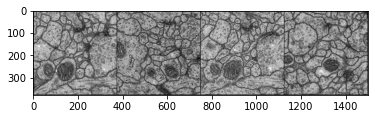

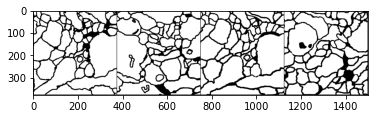

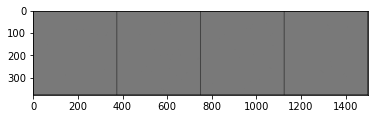

xn[0][0][0] tensor([-0.0402, -0.0427, -0.0410, -0.0423, -0.0416, -0.0430, -0.0416, -0.0432,
        -0.0434, -0.0389, -0.0428, -0.0384, -0.0400, -0.0412, -0.0374, -0.0443,
        -0.0440, -0.0477, -0.0541, -0.0554, -0.0532, -0.0513, -0.0463, -0.0446,
        -0.0389, -0.0413, -0.0375, -0.0402, -0.0470, -0.0442, -0.0439, -0.0463,
        -0.0498, -0.0469, -0.0399, -0.0378, -0.0427, -0.0437, -0.0457, -0.0499,
        -0.0499, -0.0497, -0.0484, -0.0461, -0.0439, -0.0460, -0.0445, -0.0417,
        -0.0379, -0.0440, -0.0416, -0.0367, -0.0439, -0.0401, -0.0438, -0.0470,
        -0.0441, -0.0411, -0.0465, -0.0408, -0.0410, -0.0348, -0.0425, -0.0445,
        -0.0426, -0.0391, -0.0417, -0.0391, -0.0404, -0.0422, -0.0443, -0.0446,
        -0.0433, -0.0458, -0.0535, -0.0507, -0.0449, -0.0506, -0.0458, -0.0474,
        -0.0488, -0.0436, -0.0454, -0.0425, -0.0394, -0.0398, -0.0417, -0.0449,
        -0.0462, -0.0440, -0.0407, -0.0388, -0.0421, -0.0448, -0.0438, -0.0413,
        -0.0479, -0.0497, -0

xn[0][0][0] tensor([0.1548, 0.1536, 0.1516, 0.1506, 0.1512, 0.1538, 0.1532, 0.1545, 0.1549,
        0.1471, 0.1352, 0.1304, 0.1326, 0.1374, 0.1410, 0.1433, 0.1473, 0.1491,
        0.1483, 0.1495, 0.1490, 0.1432, 0.1420, 0.1491, 0.1576, 0.1603, 0.1600,
        0.1564, 0.1546, 0.1581, 0.1617, 0.1593, 0.1598, 0.1569, 0.1533, 0.1528,
        0.1536, 0.1502, 0.1421, 0.1397, 0.1452, 0.1486, 0.1486, 0.1562, 0.1611,
        0.1598, 0.1554, 0.1576, 0.1601, 0.1594, 0.1597, 0.1614, 0.1623, 0.1652,
        0.1664, 0.1612, 0.1598, 0.1626, 0.1616, 0.1646, 0.1622, 0.1611, 0.1616,
        0.1621, 0.1619, 0.1625, 0.1607, 0.1590, 0.1600, 0.1615, 0.1616, 0.1591,
        0.1595, 0.1609, 0.1571, 0.1563, 0.1595, 0.1596, 0.1584, 0.1559, 0.1561,
        0.1550, 0.1496, 0.1441, 0.1410, 0.1424, 0.1520, 0.1570, 0.1576, 0.1555,
        0.1582, 0.1612, 0.1629, 0.1591, 0.1552, 0.1517, 0.1430, 0.1425, 0.1455,
        0.1463, 0.1448, 0.1483, 0.1521, 0.1547, 0.1573, 0.1565, 0.1573, 0.1538,
        0.1440, 0.1344, 0.13

xn[0][0][0] tensor([1.4104, 1.4081, 1.4008, 1.3941, 1.3873, 1.3871, 1.3893, 1.3933, 1.3934,
        1.3923, 1.3958, 1.4026, 1.4140, 1.4218, 1.4237, 1.4293, 1.4364, 1.4434,
        1.4479, 1.4484, 1.4507, 1.4535, 1.4533, 1.4509, 1.4455, 1.4405, 1.4400,
        1.4439, 1.4482, 1.4484, 1.4437, 1.4385, 1.4361, 1.4363, 1.4334, 1.4265,
        1.4170, 1.4059, 1.3953, 1.3897, 1.3929, 1.3997, 1.4060, 1.4144, 1.4243,
        1.4332, 1.4370, 1.4339, 1.4314, 1.4338, 1.4394, 1.4444, 1.4428, 1.4377,
        1.4352, 1.4336, 1.4323, 1.4311, 1.4302, 1.4293, 1.4280, 1.4251, 1.4215,
        1.4188, 1.4160, 1.4126, 1.4102, 1.4091, 1.4057, 1.3995, 1.3923, 1.3883,
        1.3886, 1.3916, 1.3939, 1.3941, 1.3964, 1.4035, 1.4105, 1.4132, 1.4121,
        1.4026, 1.3892, 1.3785, 1.3757, 1.3758, 1.3743, 1.3706, 1.3713, 1.3776,
        1.3877, 1.3982, 1.4060, 1.4125, 1.4183, 1.4230, 1.4221, 1.4192, 1.4160,
        1.4136, 1.4133, 1.4132, 1.4114, 1.4099, 1.4071, 1.4004, 1.3921, 1.3872,
        1.3879, 1.3905, 1.39

xn[0][0][0] tensor([0.9018, 0.8949, 0.8891, 0.8864, 0.8845, 0.8820, 0.8804, 0.8822, 0.8842,
        0.8803, 0.8757, 0.8752, 0.8832, 0.8941, 0.8991, 0.8993, 0.8988, 0.9016,
        0.9046, 0.9026, 0.8930, 0.8756, 0.8558, 0.8402, 0.8324, 0.8312, 0.8318,
        0.8381, 0.8536, 0.8739, 0.8877, 0.8923, 0.8966, 0.9013, 0.9031, 0.9006,
        0.8963, 0.8918, 0.8857, 0.8765, 0.8654, 0.8511, 0.8355, 0.8234, 0.8181,
        0.8218, 0.8318, 0.8445, 0.8602, 0.8763, 0.8855, 0.8892, 0.8932, 0.8989,
        0.9039, 0.9044, 0.9009, 0.8987, 0.9022, 0.9066, 0.9058, 0.9025, 0.9008,
        0.9019, 0.9053, 0.9036, 0.8930, 0.8756, 0.8539, 0.8349, 0.8251, 0.8240,
        0.8314, 0.8430, 0.8554, 0.8690, 0.8729, 0.8638, 0.8551, 0.8537, 0.8585,
        0.8609, 0.8531, 0.8429, 0.8404, 0.8450, 0.8490, 0.8539, 0.8611, 0.8670,
        0.8686, 0.8715, 0.8790, 0.8862, 0.8856, 0.8785, 0.8676, 0.8562, 0.8460,
        0.8380, 0.8346, 0.8348, 0.8397, 0.8479, 0.8543, 0.8572, 0.8569, 0.8570,
        0.8603, 0.8630, 0.86

xn[0][0][0] tensor([1.4081, 1.4224, 1.4313, 1.4387, 1.4455, 1.4486, 1.4422, 1.4202, 1.3937,
        1.3795, 1.3847, 1.4044, 1.4339, 1.4678, 1.4950, 1.5108, 1.5166, 1.5160,
        1.5129, 1.5077, 1.5024, 1.4970, 1.4847, 1.4649, 1.4418, 1.4262, 1.4242,
        1.4325, 1.4436, 1.4511, 1.4524, 1.4442, 1.4315, 1.4236, 1.4252, 1.4360,
        1.4561, 1.4854, 1.5046, 1.5057, 1.4967, 1.4827, 1.4694, 1.4582, 1.4497,
        1.4423, 1.4368, 1.4319, 1.4307, 1.4227, 1.4126, 1.4078, 1.4092, 1.4106,
        1.4162, 1.4322, 1.4589, 1.4782, 1.4834, 1.4825, 1.4852, 1.4982, 1.5141,
        1.5258, 1.5264, 1.5251, 1.5298, 1.5423, 1.5533, 1.5596, 1.5584, 1.5554,
        1.5511, 1.5481, 1.5493, 1.5524, 1.5607, 1.5693, 1.5746, 1.5779, 1.5775,
        1.5726, 1.5701, 1.5675, 1.5635, 1.5566, 1.5524, 1.5519, 1.5558, 1.5602,
        1.5579, 1.5501, 1.5434, 1.5441, 1.5473, 1.5477, 1.5388, 1.5239, 1.5057,
        1.4951, 1.4932, 1.4973, 1.4988, 1.4966, 1.4896, 1.4762, 1.4599, 1.4380,
        1.4177, 1.3949, 1.38

xn[0][0][0] tensor([1.2003, 1.2295, 1.2407, 1.2429, 1.2458, 1.2549, 1.2620, 1.2666, 1.2625,
        1.2612, 1.2672, 1.2732, 1.2761, 1.2690, 1.2674, 1.2640, 1.2560, 1.2401,
        1.2190, 1.1995, 1.1770, 1.1437, 1.1116, 1.0899, 1.0753, 1.0667, 1.0633,
        1.0673, 1.0576, 1.0551, 1.0523, 1.0563, 1.0652, 1.0756, 1.0831, 1.0910,
        1.1009, 1.1072, 1.1052, 1.0928, 1.0773, 1.0760, 1.0732, 1.0785, 1.0763,
        1.0793, 1.0927, 1.1084, 1.1273, 1.1338, 1.1305, 1.1203, 1.1103, 1.1105,
        1.1343, 1.1679, 1.1963, 1.2100, 1.2156, 1.2112, 1.1936, 1.1578, 1.1239,
        1.1002, 1.0901, 1.0857, 1.0790, 1.0760, 1.0807, 1.0881, 1.1032, 1.1140,
        1.1234, 1.1415, 1.1613, 1.1819, 1.2044, 1.2247, 1.2412, 1.2360, 1.2169,
        1.2031, 1.2052, 1.2180, 1.2253, 1.2348, 1.2386, 1.2288, 1.2161, 1.1984,
        1.1881, 1.1832, 1.1952, 1.2173, 1.2415, 1.2555, 1.2520, 1.2483, 1.2512,
        1.2565, 1.2583, 1.2504, 1.2389, 1.2193, 1.1983, 1.1832, 1.1684, 1.1642,
        1.1718, 1.1862, 1.20

In [19]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0

    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            print('pred.shape',pred.shape)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(
                    crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    size=(input_dim, target_shape, target_shape)
                )
                show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
            cur_step += 1

train()